```{try_on_binder}
```

In [1]:

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
    ip.run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None



The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


# Tutorial: Model order reduction for PDE-constrained optimization problems

A typical application of model order reduction for PDEs are
PDE-constrained parameter optimization problems. These problems aim to
find a local minimizer of an objective functional depending on an
underlying PDE which has to be solved for all evaluations.
A prototypical example of a PDE-constrained optimization problem can be defined
in the following way. For a physical domain {math}`\Omega \subset \mathbb{R}^d` and a
parameter set {math}`\mathcal{P} \subset \mathbb{R}^P`, we want to find
a solution of the minimization problem

```{math}
\min_{\mu \in \mathcal{P}} J(u_{\mu}, \mu),  \tag{P.a}
```

where {math}`u_{\mu} \in V := H^1_0(\Omega)` is the solution of

```{math}
\begin{equation} \label{eq:primal}
a_{\mu}(u_{\mu}, v) = f_{\mu}(v) \qquad \forall \, v \in V \tag{P.b}.
\end{equation}
```

The equation {math}`\eqref{eq:primal}` is called the primal
equation and can be arbitrarily complex. MOR methods in the context of
PDE-constrained optimization problems thus aim to find a surrogate model
of {math}`\eqref{eq:primal}` to reduce the computational costs of
an evaluation of {math}`J(u_{\mu}, \mu)`.

If there exists a unique solution {math}`u_{\mu}` for all
{math}`\mu \in \mathcal{P}`, we can rewrite (P) by using the so-called
reduced objective functional {math}`\mathcal{J}(\mu):= J(u_{\mu}, \mu)`
leading to the equivalent problem: Find a solution of

```{math}
\min_{\mu \in \mathcal{P}} \mathcal{J}(\mu).  \tag{$\hat{P}$}
```

There exist plenty of different methods to solve ({math}`\hat{P}`) by
using MOR methods. Some of them rely on an RB method with traditional
offline/online splitting, which typically result in a very online
efficient approach. Recent research also tackles overall efficiency by
overcoming the expensive offline phase, which we will discuss further
below.

In this tutorial, we use a simple linear scalar valued objective functional
and an elliptic primal equation to compare different approaches that solve
({math}`\hat{P}`).

## An elliptic model problem with a linear objective functional

We consider a domain {math}`\Omega:= [-1, 1]^2`, a parameter set
{math}`\mathcal{P} := [0,\pi]^2` and the elliptic equation

```{math}
- \nabla \cdot \big( \lambda(\mu) \nabla u_\mu \big) = l
```

with data functions

```{math}
\begin{align}
l(x, y) &= \tfrac{1}{2} \pi^2 \cos(\tfrac{1}{2} \pi x) \cos(\tfrac{1}{2} \pi y),\\
\lambda(\mu) &= \theta_0(\mu) \lambda_0 + \theta_1(\mu) \lambda_1,\\
\theta_0(\mu) &= 1.1 + \sin(\mu_0)\mu_1,\\
\theta_1(\mu) &= 1.1 + \sin(\mu_1),\\
\lambda_0 &= \chi_{\Omega \backslash \omega},\\
\lambda_1 &= \chi_\omega,\\
\omega &:= [-\tfrac{2}{3}, -\tfrac{1}{3}]^2 \cup ([-\tfrac{2}{3}, -\tfrac{1}{3}] \times [\tfrac{1}{3}, \tfrac{2}{3}]).
\end{align}
```

The diffusion is thus given as the linear combination of scaled
indicator functions where {math}`\omega` is defined by two blocks in the
left half of the domain, roughly where the `w` is here:

```
+-----------+
|           |
|  w        |
|           |
|  w        |
|           |
+-----------+
```

From the definition above we can easily deduce the bilinear form
{math}`a_{\mu}` and the linear functional {math}`f_{\mu}` for the primal
equation. Moreover, we consider the linear objective functional

```{math}

\mathcal{J}(\mu) := \theta_{\mathcal{J}}(\mu)\, f_\mu(u_\mu)

```

where {math}`\theta_{\mathcal{J}}(\mu) := 1 + \frac{1}{5}(\mu_0 + \mu_1)`.

With this data, we can construct a {{ StationaryProblem }} in pyMOR.

In [2]:
from pymor.basic import *
import numpy as np

domain = RectDomain(([-1,-1], [1,1]))
indicator_domain = ExpressionFunction(
    '(-2/3. <= x[0]) * (x[0] <= -1/3.) * (-2/3. <= x[1]) * (x[1] <= -1/3.) * 1. \
   + (-2/3. <= x[0]) * (x[0] <= -1/3.) *  (1/3. <= x[1]) * (x[1] <=  2/3.) * 1.',
    dim_domain=2)
rest_of_domain = ConstantFunction(1, 2) - indicator_domain

l = ExpressionFunction('0.5*pi*pi*cos(0.5*pi*x[0])*cos(0.5*pi*x[1])', dim_domain=2)

parameters = {'diffusion': 2}
thetas = [ExpressionParameterFunctional('1.1 + sin(diffusion[0])*diffusion[1]', parameters,
                                       derivative_expressions={'diffusion': ['cos(diffusion[0])*diffusion[1]',
                                                                             'sin(diffusion[0])']}),
          ExpressionParameterFunctional('1.1 + sin(diffusion[1])', parameters,
                                       derivative_expressions={'diffusion': ['0',
                                                                             'cos(diffusion[1])']}),

                                       ]
diffusion = LincombFunction([rest_of_domain, indicator_domain], thetas)

theta_J = ExpressionParameterFunctional('1 + 1/5 * diffusion[0] + 1/5 * diffusion[1]', parameters,
                                        derivative_expressions={'diffusion': ['1/5','1/5']})

problem = StationaryProblem(domain, l, diffusion, outputs=[('l2', l * theta_J)])

We now use pyMOR's builtin discretization toolkit (see {doc}`tutorial_builtin_discretizer`)
to construct a full order {{ StationaryModel }}. Since we intend to use a fixed
energy norm

```{math}
\|\,.\|_{\bar{\mu}} : = a_{\,\bar{\mu}}(.,.),
```

we also define {math}`\bar{\mu}`, which we pass via the argument
`mu_energy_product`. Also, we define the parameter space
{math}`\mathcal{P}` on which we want to optimize.

In [3]:
mu_bar = problem.parameters.parse([np.pi/2,np.pi/2])

fom, data = discretize_stationary_cg(problem, diameter=1/50, mu_energy_product=mu_bar)
parameter_space = fom.parameters.space(0, np.pi)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

We now define the first function for the output of the model that will be used by the minimizer.

In [4]:
def fom_objective_functional(mu):
    return fom.output(mu)[0]

We also pick a starting parameter for the optimization method,
which in our case is {math}`\mu^0 = (0.25, 0.5)`.

In [5]:
initial_guess = [0.25, 0.5]

Next, we visualize the diffusion function {math}`\lambda_\mu` by using
{class}`~pymor.discretizers.builtin.cg.InterpolationOperator` for interpolating it on the grid.

In [6]:
from pymor.discretizers.builtin.cg import InterpolationOperator

diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(fom.parameters.parse(initial_guess))
fom.visualize(diff)

Output()

In [7]:
print(data['grid'])

Tria-Grid on domain [-1,1] x [-1,1]
x0-intervals: 100, x1-intervals: 100
elements: 40000, edges: 60200, vertices: 20201


We can see that our FOM model has 20201 DoFs which just about suffices
to resolve the data structure in the diffusion. This suggests to use an
even finer mesh. However, for enabling a faster runtime for this
tutorial, we stick with this mesh and remark that refining the mesh does
not change the interpretation of the methods that are discussed below.
It rather further improves the speedups achieved by model reduction.

Before we discuss the first optimization method, we define helpful
functions for visualizations.

In [8]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.subplot.bottom'] = .1
mpl.rcParams['axes.facecolor'] = (0.0, 0.0, 0.0, 0.0)

from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
from matplotlib import cm # required for colors

import matplotlib.pyplot as plt
from time import perf_counter

def compute_value_matrix(f, x, y):
    f_of_x = np.zeros((len(x), len(y)))
    for ii in range(len(x)):
        for jj in range(len(y)):
            f_of_x[ii][jj] = f((x[ii], y[jj]))
    x, y = np.meshgrid(x, y)
    return x, y, f_of_x

def plot_3d_surface(f, x, y, alpha=1):
    X, Y = x, y
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, f_of_x = compute_value_matrix(f, x, y)
    ax.plot_surface(x, y, f_of_x, cmap='Blues',
                    linewidth=0, antialiased=False, alpha=alpha)
    ax.view_init(elev=27.7597402597, azim=-39.6370967742)
    ax.set_xlim3d([-0.10457963, 3.2961723])
    ax.set_ylim3d([-0.10457963, 3.29617229])
    return ax

def addplot_xy_point_as_bar(ax, x, y, color='orange', z_range=None):
    ax.plot([y, y], [x, x], z_range if z_range else ax.get_zlim(), color)

Now, we can visualize the objective functional on the parameter space

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

<Axes3DSubplot:>

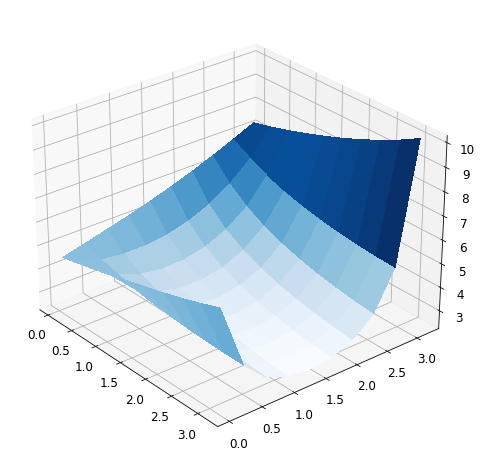

In [9]:
ranges = parameter_space.ranges['diffusion']
XX = np.linspace(ranges[0] + 0.05, ranges[1], 10)

plot_3d_surface(fom_objective_functional, XX, XX)

Taking a closer look at the functional, we see that it is at least
locally convex with a locally unique minimum. In general, however,
PDE-constrained optimization problems are not convex. In our case
changing the parameter functional {math}`\theta_{\mathcal{J}}` can
already result in a very different non-convex output functional.

In order to record some data during the optimization, we also define
helpful functions for recording and reporting the results in this tutorial.

In [10]:
def prepare_data(offline_time=False, enrichments=False):
    data = {'num_evals': 0, 'evaluations' : [], 'evaluation_points': [], 'time': np.inf}
    if offline_time:
        data['offline_time'] = offline_time
    if enrichments:
        data['enrichments'] = 0
    return data

def record_results(function, data, adaptive_enrichment=False, opt_dict=None, mu=None):
    if adaptive_enrichment:
        # this is for the adaptive case! rom is shiped via the opt_dict argument.
        assert opt_dict is not None
        QoI, data, rom = function(mu, data, opt_dict)
        opt_dict['opt_rom'] = rom
    else:
        QoI = function(mu)
    data['num_evals'] += 1
    data['evaluation_points'].append(mu)
    data['evaluations'].append(QoI[0])
    return QoI

def report(result, data, reference_mu=None):
    if (result.status != 0):
        print('\n failed!')
    else:
        print('\n succeeded!')
        print(f'  mu_min:    {fom.parameters.parse(result.x)}')
        print(f'  J(mu_min): {result.fun[0]}')
        if reference_mu is not None:
            print(f'  absolute error w.r.t. reference solution: {np.linalg.norm(result.x-reference_mu):.2e}')
        print(f'  num iterations:     {result.nit}')
        print(f'  num function calls: {data["num_evals"]}')
        print(f'  time:               {data["time"]:.5f} seconds')
        if 'offline_time' in data:
                print(f'  offline time:       {data["offline_time"]:.5f} seconds')
        if 'enrichments' in data:
                print(f'  model enrichments:  {data["enrichments"]}')
    print('')

## Optimizing with the FOM using finite differences

There exist plenty optimization methods, and this tutorial is not meant
to discuss the design and implementation of optimization methods. We
simply use the {func}`~scipy.optimize.minimize` function
from `scipy.optimize` and use the
builtin `L-BFGS-B` routine which is a quasi-Newton method that can
also handle a constrained parameter space. For the whole tutorial, we define the
optimization function as follows.

In [11]:
from functools import partial
from scipy.optimize import minimize

def optimize(J, data, ranges, gradient=False, adaptive_enrichment=False, opt_dict=None):
    tic = perf_counter()
    result = minimize(partial(record_results, J, data, adaptive_enrichment, opt_dict),
                      initial_guess,
                      method='L-BFGS-B', jac=gradient,
                      bounds=(ranges, ranges),
                      options={'ftol': 1e-15, 'gtol': 5e-5})
    data['time'] = perf_counter()-tic
    return result

It is optional to give an expression for the gradient of the objective
functional to the {func}`~scipy.optimize.minimize` function.
In case no gradient is given, {func}`~scipy.optimize.minimize`
just approximates the gradient with finite differences.
This is not recommended because the gradient is inexact and the
computation of finite differences requires even more evaluations of the
primal equation. Here, we use this approach for a simple demonstration.

In [12]:
reference_minimization_data = prepare_data()

fom_result = optimize(fom_objective_functional, reference_minimization_data, ranges)

reference_mu = fom_result.x

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [13]:
report(fom_result, reference_minimization_data)


 succeeded!
  mu_min:    {diffusion: [1.4246136067091022, 3.141592653589793]}
  J(mu_min): 2.3917078784322223
  num iterations:     7
  num function calls: 27
  time:               2.41854 seconds



Taking a look at the result, we see that the optimizer needs {math}`7`
iterations to converge, but actually needs {math}`27` evaluations of the
full order model. Obviously, this is related to the computation of the
finite differences. We can visualize the optimization path by plotting
the chosen points during the minimization.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

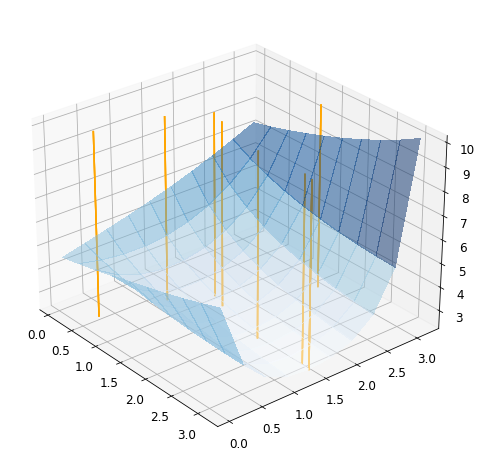

In [14]:
reference_plot = plot_3d_surface(fom_objective_functional, XX, XX, alpha=0.5)

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1])

## Optimizing with the ROM using finite differences

We can use a standard RB method to build a surrogate model for the FOM.
As a result, the solution of the primal equation is no longer expensive
and the optimization method can evaluate the objective functional quickly.
For this, we define a standard {class}`~pymor.reductors.coercive.CoerciveRBReductor`
and use the {class}`~pymor.parameters.functionals.MinThetaParameterFunctional` for an
estimation of the coerciviy constant.

In [15]:
from pymor.algorithms.greedy import rb_greedy
from pymor.parameters.functionals import MinThetaParameterFunctional
from pymor.reductors.coercive import CoerciveRBReductor

coercivity_estimator = MinThetaParameterFunctional(fom.operator.coefficients, mu_bar)

The online efficiency of MOR methods most likely comes with a
rather expensive offline phase. For PDE-constrained optimization, however,
it is not meaningful to ignore the
offline time of the surrogate model since it can happen that FOM
optimization methods would already converge before the surrogate model
is even ready. Thus, RB optimization methods (at least for only one
configuration) aims for overall efficiency which includes offline and
online time. Of course, this effect aggravates if the parameter space is
high dimensional because the offline phase can increase even more.

In order to decrease the offline time we guess that we may not require
a perfect surrogate model in the sense that a low error tolerance for
the {func}`~pymor.algorithms.greedy.rb_greedy` already suffices to converge
to the same minimum.
In our case we choose `atol=1e-2` and yield a very low dimensional space.
In general, however, it is not a priori clear how to choose `atol`
in order to arrive at a minimum which is close enough to the true
optimum.

In [16]:
training_set = parameter_space.sample_uniformly(25)

RB_reductor = CoerciveRBReductor(fom, product=fom.energy_product, coercivity_estimator=coercivity_estimator)
RB_greedy_data = rb_greedy(fom, RB_reductor, training_set, atol=1e-2)

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']
rom = RB_greedy_data['rom']

print(f'RB system is of size {num_RB_greedy_extensions}x{num_RB_greedy_extensions}')
print(f'maximum estimated model reduction error over training set: {RB_greedy_errors[-1]}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

RB system is of size 3x3
maximum estimated model reduction error over training set: 0.00935354954250121


We can see that greedy algorithm already stops after {math}`3` basis functions.
Next, we plot the chosen parameters.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

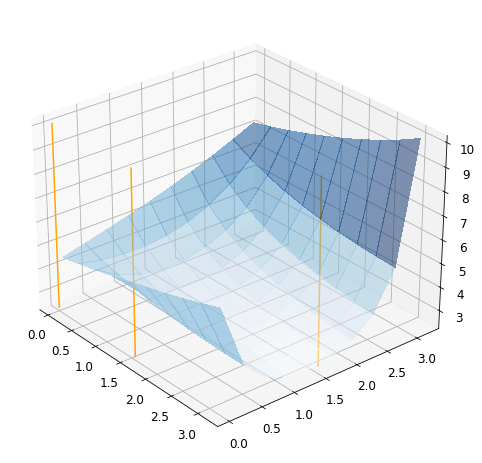

In [17]:
ax = plot_3d_surface(fom_objective_functional, XX, XX, alpha=0.5)

for mu in RB_greedy_mus[:-1]:
    mu = mu.to_numpy()
    addplot_xy_point_as_bar(ax, mu[0], mu[1])

Analogously to above, we perform the same optimization method, but use
the resulting ROM objective functional.

In [18]:
def rom_objective_functional(mu):
    return rom.output(mu)[0]

RB_minimization_data = prepare_data(offline_time=RB_greedy_data['time'])

rom_result = optimize(rom_objective_functional, RB_minimization_data, ranges)

In [19]:
report(rom_result, RB_minimization_data, reference_mu)


 succeeded!
  mu_min:    {diffusion: [1.4246541841658669, 3.141592653589793]}
  J(mu_min): 2.3917078350968275
  absolute error w.r.t. reference solution: 4.06e-05
  num iterations:     7
  num function calls: 27
  time:               0.01572 seconds
  offline time:       1.96409 seconds



Comparing the result to the FOM model, we see that the number of
iterations and evaluations of the model are equal. As expected,
we see that the optmization routine is very fast because the surrogate
enables almost instant evaluations of the primal equation.

As mentioned above, we should not forget that we required the offline
time to build our surrogate. In our case, the offline time is still low
enough to get a speed up over the FOM optimization. Luckily,
`atol=1e-2` was enough to achieve an absolute error of roughly `1e-06`
but it is important to notice that we do not know this error before
choosing `atol`.

To show that the ROM optimization roughly followed the same path as the
FOM optimization, we visualize both of them in the following plot.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

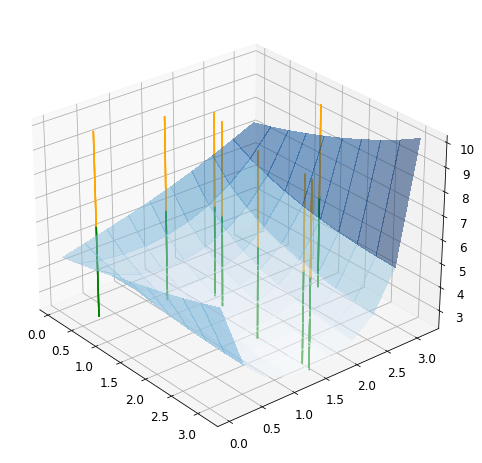

In [20]:
reference_plot = plot_3d_surface(fom_objective_functional, XX, XX, alpha=0.5)
reference_plot_mean_z_lim = 0.5*(reference_plot.get_zlim()[0] + reference_plot.get_zlim()[1])

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1], color='green',
                            z_range=(reference_plot.get_zlim()[0], reference_plot_mean_z_lim))

for mu in RB_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1], color='orange',
                           z_range=(reference_plot_mean_z_lim, reference_plot.get_zlim()[1]))

## Computing the gradient of the objective functional

A major issue of using finite differences for computing the gradient of
the objective functional is the number of evaluations of the objective
functional. In the FOM example from above we saw that
many evaluations of the model were only due to the
computation of the finite differences. If the problem is more complex
and the mesh is finer, this can lead to a serious waste of
computational time. Also from an optimizational point of view it is
always better to compute the true gradient of the objective functional.

For computing the gradient of the linear objective functional
{math}`\mathcal{J}(\mu)`, we can write for every direction
{math}`i= 1, \dots, P`

```{math}
\begin{align} \label{gradient:sens} \tag{1}
d_{\mu_i} \mathcal{J}(\mu) = \partial_{\mu_i} J(u_{\mu}, \mu) + \partial_u J(u_{\mu}, \mu)[d_{\mu_i} u_{\mu}]
   =   \partial_{\mu_i} J(u_{\mu}, \mu) + J(d_{\mu_i} u_{\mu}, \mu)
\end{align}
```

Thus, we need to compute the derivative of the
solution {math}`u_{\mu}` (also called sensitivity). For this, we need to
solve another equation: Find {math}`d_{\mu_i} u_{\mu} \in V`, such that

```{math}
 \label{sens} \tag{2}
a_\mu(d_{\mu_i} u_{\mu}, v) = \partial_{\mu_i} r_\mu^{\text{pr}}(u_{\mu})[v] \qquad \qquad \forall v \in V
```

where {math}`r_\mu^{\text{pr}}` denotes the residual of the primal
equation, i.e.

```{math}
r_\mu^{\text{pr}}(u)[v] := l_\mu(v) - a_\mu(u, v) \qquad \qquad \text{for all }v \in V
```

A major issue of this approach is that the computation of the
full gradient requires {math}`P` solutions of {math}`\eqref{sens}`.
Especially for high dimensional parameter spaces, we can instead use an
adjoint approach to reduce the computational cost to only one solution
of an additional problem.

The adjoint approach relies on the Lagrangian of the objective
functional

```{math}
\mathcal{L}(u, \mu, p) = J(u, \mu) + r_\mu^{\text{pr}}(u, p)
```

where {math}`p \in V` is the adjoint variable. Deriving optimality
conditions for {math}`\mathcal{L}`, we end up with the dual equation:
Find {math}`p_{\mu} \in V`, such that

```{math}
 \label{dual} \tag{3}
a_\mu(v, p_\mu) = \partial_u J(u_\mu, \mu)[v]
= J(v, \mu)
```

Note that in our case, we then have
{math}`\mathcal{L}(u_{\mu}, \mu, p_{\mu}) = J(u, \mu)` because the
residual term {math}`r_\mu^{\text{pr}}(u_{\mu}, p_{\mu})` vanishes since {math}`u_{\mu}`
solves {math}`\eqref{eq:primal}` and {math}`p_{\mu}` is in the test space {math}`V`. By
using the solution of the dual problem, we can then derive the gradient of the objective
functional by

```{math}
\begin{align}
d_{\mu_i} \mathcal{J}(\mu) &= \partial_{\mu_i} J(u_{\mu}, \mu) + \partial_u J(u_{\mu}, \mu)[d_{\mu_i} u_{\mu}] \\
   &=   \partial_{\mu_i} J(u_{\mu}, \mu) + a_\mu(d_{\mu_i} u_{\mu}, p_\mu) \\
   &=   \partial_{\mu_i} J(u_{\mu}, \mu) + \partial_{\mu_i} r_\mu^{\text{pr}}(d_{\mu_i} u_{\mu})[p_\mu]
\end{align}
```

We conclude that we only need to solve for {math}`u_{\mu}` and
{math}`p_{\mu}` if we want to compute the gradient with the adjoint
approach. For more information on this approach we refer to Section 1.6.2 in {cite}`HPUU09`.

We now intend to use the gradient to speed up the optimization methods
from above. All technical requirements are
already available in pyMOR.

## Optimizing using a gradient in FOM

We can easily include a function to compute the gradient to {func}`~scipy.optimize.minimize`.
Since we use a linear operator and a linear objective functional, the `use_adjoint` argument
is automatically enabled.
Note that using the (more general) implementation `use_adjoint=False` results
in the exact same gradient but lacks computational speed.
Moreover, the function `output_d_mu` returns a dict w.r.t. the parameters as default.
In order to use the output for {func}`~scipy.optimize.minimize` we thus use the `return_array=True` argument.

In [21]:
def fom_gradient_of_functional(mu):
    return fom.output_d_mu(fom.parameters.parse(mu), return_array=True, use_adjoint=True)

opt_fom_minimization_data = prepare_data()

opt_fom_result = optimize(fom_objective_functional, opt_fom_minimization_data, ranges,
                          gradient=fom_gradient_of_functional)

# update the reference_mu because this is more accurate!
reference_mu = opt_fom_result.x

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [22]:
report(opt_fom_result, opt_fom_minimization_data)


 succeeded!
  mu_min:    {diffusion: [1.4246556963614532, 3.141592653589793]}
  J(mu_min): 2.391707876213191
  num iterations:     7
  num function calls: 9
  time:               2.38369 seconds



With respect to the FOM result with finite differences, we see that we
have a saved the evaluations for computing the gradient. Of course it is also not for free to
compute the gradient, but since we are using the dual approach, this will only scale with the
factor 2. Furthermore, we can expect that the result above is more accurate which is why we
choose it as the reference parameter.

## Optimizing using a gradient in ROM

Obviously, we can also include the gradient of the ROM version of the
output functional.

In [23]:
def rom_gradient_of_functional(mu):
    return rom.output_d_mu(rom.parameters.parse(mu), return_array=True, use_adjoint=True)

opt_rom_minimization_data = prepare_data(offline_time=RB_greedy_data['time'])

opt_rom_result = optimize(rom_objective_functional, opt_rom_minimization_data, ranges,
                          gradient=rom_gradient_of_functional)

In [24]:
report(opt_rom_result, opt_rom_minimization_data, reference_mu)


 succeeded!
  mu_min:    {diffusion: [1.4246542368580375, 3.141592653589793]}
  J(mu_min): 2.3917078350958616
  absolute error w.r.t. reference solution: 1.46e-06
  num iterations:     7
  num function calls: 9
  time:               0.02669 seconds
  offline time:       1.96409 seconds



The online phase is even faster but the offline time of course remains the same.
We also conclude that the ROM model eventually gives less speedup by using a better optimization
method for the FOM and ROM.

## Beyond the traditional offline/online splitting: enrich along the path of optimization

We already figured out that the main drawback for using RB methods in the
context of optimization is the expensive offline time to build the
surrogate model. In the example above, we overcame this issue by
choosing a large tolerance `atol`. As a result, we cannot be sure
that our surrogate model is accurate enough for our purpuses. In other
words, either we invest too much time to build an accurate model or we
face the danger of reducing with a bad surrogate for the whole parameter
space. Thinking about this issue again, it is important to notice that
we are solving an optimization problem which will eventually converge to
a certain parameter. Thus, it only matters that the surrogate is good in
this particular region as long as we are able to arrive at it. This
gives hope that there must exist a more efficient way of using RB
methods without trying to approximate the FOM across the
whole parameter space.

One possible way for advanced RB methods is a reduction along the path
of optimization. The idea is that we start with an empty basis and only
enrich the model with the parameters that we will arive at. This
approach goes beyond the classical offline/online splitting of RB
methods since it entirely skips the offline phase. In the following
code, we will test this method.

In [25]:
pdeopt_reductor = CoerciveRBReductor(
    fom, product=fom.energy_product, coercivity_estimator=coercivity_estimator)

In the next function, we implement the above mentioned way of enriching
the basis along the path of optimization.

In [26]:
def enrich_and_compute_objective_function(mu, data, opt_dict):
    U = fom.solve(mu)
    try:
        pdeopt_reductor.extend_basis(U)
        data['enrichments'] += 1
    except:
        print('Extension failed')
    opt_rom = pdeopt_reductor.reduce()
    QoI = opt_rom.output(mu)
    return QoI, data, opt_rom

def compute_gradient_with_opt_rom(opt_dict, mu):
    opt_rom = opt_dict['opt_rom']
    return opt_rom.output_d_mu(opt_rom.parameters.parse(mu), return_array=True, use_adjoint=True)

With this definitions, we can start the optimization method.

In [27]:
opt_along_path_minimization_data = prepare_data(enrichments=True)

opt_dict = {}
opt_along_path_result = optimize(enrich_and_compute_objective_function,
                                 opt_along_path_minimization_data, ranges,
                                 gradient=partial(compute_gradient_with_opt_rom, opt_dict),
                                 adaptive_enrichment=True, opt_dict=opt_dict)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [28]:
report(opt_along_path_result, opt_along_path_minimization_data, reference_mu)


 succeeded!
  mu_min:    {diffusion: [1.424655696361452, 3.141592653589793]}
  J(mu_min): [2.39170788]
  absolute error w.r.t. reference solution: 1.11e-15
  num iterations:     7
  num function calls: 9
  time:               1.42785 seconds
  model enrichments:  9



The computational time looks at least better than the FOM optimization
and we are very close to the reference parameter.
But we are following the exact same path than the
FOM and thus we need to solve the FOM model as often as before
(due to the enrichments). The only computational time that we safe is the one
for the gradients since we compute the dual solutions with the ROM.

## Adaptively enriching along the path

In order to further speedup the above algorithm, we enhance it
by only adaptive enrichments of the model.
For instance it may happen that the model is already good at
the next iteration, which we can easily check by evaluating the standard
error estimator which is also used in the greedy algorithm. In the next
example we will implement this adaptive way of enriching and set a
tolerance which is equal to the one that we had as error tolerance
in the greedy algorithm.

In [29]:
pdeopt_reductor = CoerciveRBReductor(
    fom, product=fom.energy_product, coercivity_estimator=coercivity_estimator)
opt_rom = pdeopt_reductor.reduce()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [30]:
def enrich_adaptively_and_compute_objective_function(mu, data, opt_dict):
    opt_rom = opt_dict['opt_rom']
    primal_estimate = opt_rom.estimate_error(opt_rom.parameters.parse(mu))
    if primal_estimate > 1e-2:
        print('Enriching the space because primal estimate is {} ...'.format(primal_estimate))
        U = fom.solve(mu)
        try:
            pdeopt_reductor.extend_basis(U)
            data['enrichments'] += 1
            opt_rom = pdeopt_reductor.reduce()
        except:
            print('... Extension failed')
    else:
        print('Do NOT enrich the space because primal estimate is {} ...'.format(primal_estimate))
    opt_rom = pdeopt_reductor.reduce()
    QoI = opt_rom.output(mu)
    return QoI, data, opt_rom

In [31]:
opt_along_path_adaptively_minimization_data = prepare_data(enrichments=True)

opt_dict = {'opt_rom': opt_rom}
opt_along_path_adaptively_result = optimize(enrich_adaptively_and_compute_objective_function,
                                            opt_along_path_adaptively_minimization_data, ranges,
                                            gradient=partial(compute_gradient_with_opt_rom, opt_dict),
                                            adaptive_enrichment=True, opt_dict=opt_dict)

Enriching the space because primal estimate is [2.98580267] ...


Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Enriching the space because primal estimate is [0.08625045] ...


Do NOT enrich the space because primal estimate is [0.00063044] ...
Do NOT enrich the space because primal estimate is [0.00122583] ...
Do NOT enrich the space because primal estimate is [0.00234427] ...
Enriching the space because primal estimate is [0.0135848] ...


Enriching the space because primal estimate is [0.01046669] ...


Do NOT enrich the space because primal estimate is [0.00078205] ...
Do NOT enrich the space because primal estimate is [0.00078226] ...


In [32]:
report(opt_along_path_adaptively_result, opt_along_path_adaptively_minimization_data, reference_mu)


 succeeded!
  mu_min:    {diffusion: [1.4246559756652408, 3.141592653589793]}
  J(mu_min): [2.39170756]
  absolute error w.r.t. reference solution: 2.79e-07
  num iterations:     7
  num function calls: 9
  time:               0.64514 seconds
  model enrichments:  4



Now, we actually only needed {math}`4` enrichments and ended up with an
approximation error of about `1e-07` while getting the highest speed up
amongst all methods that we have seen above. Note, however, that this is
still dependent on the tolerance `atol=1e-2` that we chose without
knowing that this tolerance suffices to reach the actual minimum.
An easy way around this would be to do one optimization step with the FOM
after converging. If this changes anything, the ROM tolerance `atol`
was too large. To conclude, we once again
compare all methods that we have discussed in this notebook.

In [33]:
print('FOM with finite differences')
report(fom_result, reference_minimization_data, reference_mu)

print('\nROM with finite differences')
report(rom_result, RB_minimization_data, reference_mu)

print('\nFOM with gradient')
report(opt_fom_result, opt_fom_minimization_data, reference_mu)

print('\nROM with gradient')
report(opt_rom_result, opt_rom_minimization_data, reference_mu)

print('\nAlways enrich along the path')
report(opt_along_path_result, opt_along_path_minimization_data, reference_mu)

print('\nAdaptively enrich along the path')
report(opt_along_path_adaptively_result, opt_along_path_adaptively_minimization_data, reference_mu)

FOM with finite differences

 succeeded!
  mu_min:    {diffusion: [1.4246136067091022, 3.141592653589793]}
  J(mu_min): 2.3917078784322223
  absolute error w.r.t. reference solution: 4.21e-05
  num iterations:     7
  num function calls: 27
  time:               2.41854 seconds


ROM with finite differences

 succeeded!
  mu_min:    {diffusion: [1.4246541841658669, 3.141592653589793]}
  J(mu_min): 2.3917078350968275
  absolute error w.r.t. reference solution: 1.51e-06
  num iterations:     7
  num function calls: 27
  time:               0.01572 seconds
  offline time:       1.96409 seconds


FOM with gradient

 succeeded!
  mu_min:    {diffusion: [1.4246556963614532, 3.141592653589793]}
  J(mu_min): 2.391707876213191
  absolute error w.r.t. reference solution: 0.00e+00
  num iterations:     7
  num function calls: 9
  time:               2.38369 seconds


ROM with gradient

 succeeded!
  mu_min:    {diffusion: [1.4246542368580375, 3.141592653589793]}
  J(mu_min): 2.3917078350958616
  

In [34]:
assert fom_result.nit == 7
assert opt_along_path_result.nit == 7
assert opt_along_path_minimization_data['num_evals'] == 9
assert opt_along_path_minimization_data['enrichments'] == 9
assert opt_along_path_adaptively_minimization_data['enrichments'] == 4

## Conclusion and some general words about MOR methods for optimization

In this tutorial we have seen how pyMOR can be used to speedup the optimizer
for PDE-constrained optimization problems.
We focused on several aspects of RB methods and showed how explicit gradient information
helps to reduce the computational cost of the optimizer.
We also saw that already standard RB methods may help to reduce the computational time.
It is clear that standard RB methods are especially of interest if an
optimization problem needs to be solved multiple times.

Moreover, we focused on the lack of overall efficiency of standard RB methods.
To overcome this, we reduced the (normally) expensive offline time by choosing larger
tolerances for the greedy algorithm.
We have also seen a way to overcome
the traditional offline/online splitting by only enriching the model along
the path of optimization or (even better) only enrich
the model if the standard error estimator goes above a certain tolerance.

In this tutorial we have only covered a few basic approaches to combine model
reduction with optimization.
For faster and more robust optimization algorithms we refer to the textbooks
[CGT00](<https://epubs.siam.org/doi/book/10.1137/1.9780898719857>) and
[NW06](<https://link.springer.com/book/10.1007/978-0-387-40065-5>).
For recent research on combining trust-region methods with model reduction for
PDE-constrained optimization problems we refer to
[YM13](<https://epubs.siam.org/doi/abs/10.1137/120869171>),
[QGVW17](<https://epubs.siam.org/doi/abs/10.1137/16M1081981>) and
[KMSOV20](<https://arxiv.org/abs/2006.09297>) where for the latter a pyMOR
implementation is available as supplementary material.

Download the code:
{download}`tutorial_optimization.md`
{nb-download}`tutorial_optimization.ipynb`